<a href="https://colab.research.google.com/github/YuHsin-Chen1221/NeuroAI-Summer-School-25/blob/main/LIF_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2025 NeuroAI Summer School**
# Leaky integrate-an-fire model



In [1]:
#@title **0: Setup**

!pip -q install "brian2>=2.7,<2.9" brian2tools


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")  # Make the system quiet

import numpy as np
import brian2
from brian2 import *


print(f"Brian2 version: {brian2.__version__}")
np.random.seed(42)
seed(42)  # Brian2's random seed

# Timestep of the simulations
defaultclock.dt = 0.1*ms  # 0.1 ms is a typical value for the LIF model

prefs.codegen.target = 'numpy'

print(f"Default dt = {defaultclock.dt}")
print(f"Codegen target = {prefs.codegen.target}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.8/390.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
Brian2 version: 2.8.0.4
Default dt = 100. us
Codegen target = numpy


In [2]:
#@title **1: Set up the LIF neuron model**
start_scope()

# Define neuronal parameters
tau_m   = 20*ms
EL      = -70*mV
v_reset = -70*mV
v_thresh_default = -50*mV
t_ref   = 2*ms
R       = 100*Mohm

# Define parameters for plots
y_min, y_max = -80*mV, 0*mV
spike_bottom, spike_top = v_thresh_default, 0*mV

# Equation for the LIF model equation and variables
eqs = '''
dv/dt = (-(v - EL) + R*I)/tau_m : volt (unless refractory)
ref : second
I : amp
tau_m : second
v_th : volt
v_reset_var : volt
'''

# Define the neuron group and parameters
G = NeuronGroup(
    1, eqs,
    threshold='v > v_th',
    reset='v = v_reset_var',
    refractory='ref',
    method='exact'
)

G.v     = EL
G.ref   = t_ref
G.I     = 0*nA
G.tau_m = tau_m
G.v_th  = v_thresh_default

# Record the membrane potential and spikes
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

store()


#Test 1: The subthreshold dynamics

In the test 1 let us just examine the subthreshold dynamics of a LIF neuron.
We raise the spike threshold so that the LIF neuron does not fire. This allows us to observe the subthreshold dynamcis more easily.

You can adjust the levels of two brief input currents that start at t=100ms and 500ms, respectively. Each current lasts only 200ms.

1.   Observe carefully how the membrane potential responds to the inputs.
2.   Tune "membrane_tau" and observe how the membrane potential responds to the inputs.



WARNING    'tau_m' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 20. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Text(0.5, 1.0, 'LIF membrane response, tau = 50 ms')

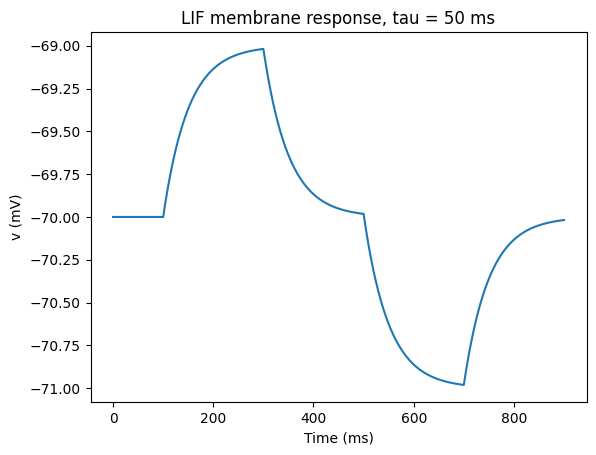

In [3]:
#@title **2: Run Test1 (current steps + tau slider)**
restore()

# 設很高的門檻，保證不產生 spike
G.v_th = 1*volt

I1 = 0.01    #@param {type:"slider", min:-0.1, max:0.1, step:0.005}
I2 = -0.01  #@param {type:"slider", min:-0.1, max:0.1, step:0.005}
membrane_tau = 50  #@param {type:"slider", min:1.0, max:50, step:1.0}

G.tau_m = membrane_tau*ms


G.I = 0*nA;      run(100*ms)
G.I = I1*nA;     run(200*ms)
G.I = 0*nA;      run(200*ms)
G.I = I2*nA;     run(200*ms)
G.I = 0*nA;      run(200*ms)

plot(M.t/ms, M.v[0]/mV)
xlabel('Time (ms)')
ylabel('v (mV)')
title(f'LIF membrane response, tau = {membrane_tau} ms')


#Test 2: The spiking properties of the LIF model

Now we reset the spike threshold to a normal level so that the neuron can fire.


1.   Tune each parameter (Input, refractory period and reset potential) and observe how they affect the firing rate of the neuron.
2.   Vary the input level with refract_t = 2, v_reset=-0.07. Plot a F-I curve.
3.   Plot F-I curves for refract_t = 0, 2, and 6ms.








WARNING    'tau_m' is an internal variable of group 'lif', but also exists in the run namespace with the value 20. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Number of spikes = 18


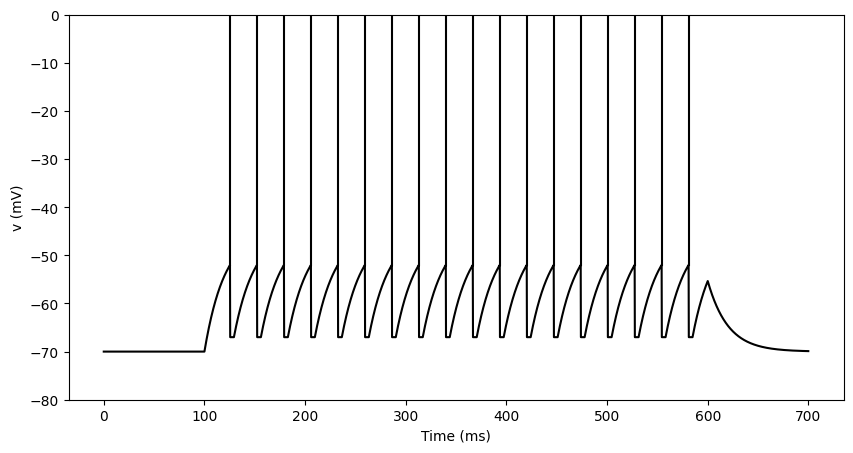

In [4]:
#@title **3: Run Test2 (spiking + refractory) — robust (no restore pitfalls)**
start_scope()  # 清空上一段的物件，避免 store/restore 物件集合不一致問題

# ---- 模型常數（與第 2 段一致）----
EL   = -70*mV
R    = 100*Mohm

# 方程式：門檻與 reset 都做成可調欄位
eqs = '''
dv/dt = (-(v - EL) + R*I)/tau_m : volt (unless refractory)
ref : second
I : amp
tau_m : second
v_th : volt
v_reset_var : volt
'''

# 建立神經元（1 顆 LIF）
G = NeuronGroup(
    1, eqs,
    threshold='v > v_th',
    reset='v = v_reset_var',
    refractory='ref',
    method='exact',
    name='lif'
)

# ---- 滑桿參數----
v_threshold = -0.052   #@param {type:"slider", min:-0.08, max:-0.04, step:0.001}
Input      = 0.25    #@param {type:"slider", min:0.0, max:0.5,  step:0.005}
refrac_t   = 3.9      #@param {type:"slider", min:0.0, max:10.0, step:0.1}
v_reset    = -0.067    #@param {type:"slider", min:-0.08, max:-0.055, step:0.001}
tau_value  = 20.0     # 這段固定 20 ms

# ---- 初始化狀態 ----
G.v           = EL
G.I           = 0*nA
G.tau_m       = tau_value*ms
G.v_th        = v_threshold*volt
G.v_reset_var = v_reset*volt
G.ref         = refrac_t*ms

# 紀錄系統狀態與輸出（給固定名字，避免自動遞增命名）
M = StateMonitor(G, 'v', record=True, name='mon_v')
spikemon = SpikeMonitor(G, name='mon_spk')

# ---- 刺激流程 ----
G.I = 0*nA;        run(100*ms)
G.I = Input*nA;    run(500*ms)
G.I = 0*nA;        run(100*ms)

# ---- 繪圖（電壓 + 人工畫出 spike 線段）----
figure(figsize=(10, 5))
plot(M.t/ms, M.v[0]/mV, color='black')

spike_top    = 0*mV
spike_bottom = G.v_th[0]  # 以目前門檻當作線段底部
for t in spikemon.t:
    plot([t/ms, t/ms], [float(spike_top/mV), float(spike_bottom/mV)], color='black')

ylim([-80, 0])  # mV
xlabel('Time (ms)'); ylabel('v (mV)')
print("Number of spikes =", int(spikemon.count[0]))



#Test 3: The persistent activity by recurrent excitation



Spikes: N0=0, N1=0
Tips: Increase w_nA or Iext_nA to trigger persistent activity; increase sigma_nA to desynchronize spikes.


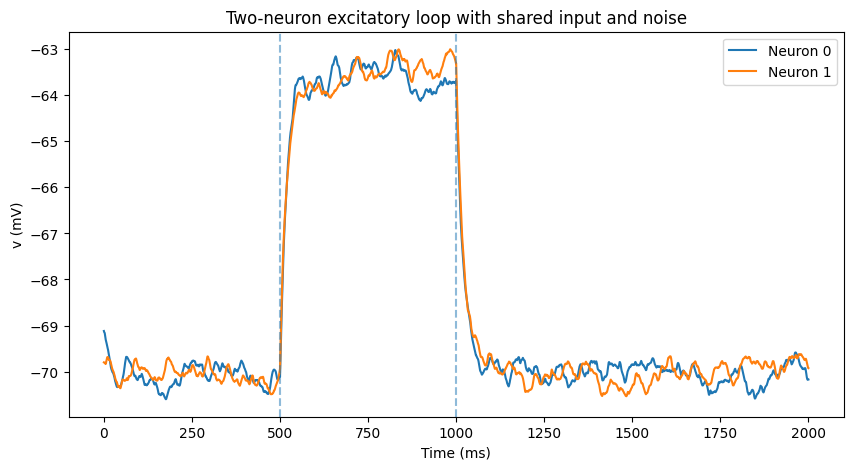

In [9]:
#@title **4: Two-neuron excitatory loop with shared input & per-neuron noise**
start_scope()

# ===== 基本參數 =====
EL        = -70*mV
R         = 100*Mohm
tau_syn   = 5*ms
delay_e   = 1*ms

w_nA        = 0.37  #@param {type:"slider", min:0.0, max:2.0, step:0.01}
Iext_nA     = 0.064  #@param {type:"slider", min:0.0, max:0.3, step:0.001}
sigma_nA    = 0.005
tau_noise_ms= 5.0
v_reset     = -0.065
v_thresh    = -0.050
refrac_t    = 2.0
tau_m_ms    = 20.0

# ===== 方程式：LIF + 突觸電流 + OU 雜訊電流 =====
# dv/dt = (-(v - EL) + R*(I_ext + I_syn + I_noise)) / tau_m
# dI_syn/dt = -I_syn/tau_syn
# dI_noise/dt = -I_noise/tau_noise + sigma_noise*xi*sqrt(2/tau_noise)
eqs = '''
dv/dt       = (-(v - EL) + R*(I_ext + I_syn + I_noise)) / tau_m : volt (unless refractory)
dI_syn/dt   = -I_syn/tau_syn                                     : amp
dI_noise/dt = -I_noise/tau_noise + sigma_noise*xi*sqrt(2/tau_noise) : amp
I_ext                                                            : amp
tau_m                                                           : second
v_th                                                            : volt
v_reset_var                                                     : volt
ref                                                             : second
tau_noise                                                       : second
sigma_noise                                                     : amp
'''

# 兩顆 LIF neuron
G = NeuronGroup(
    2, eqs,
    threshold='v > v_th',
    reset='v = v_reset_var',
    refractory='ref',
    method='euler',
    name='lif2_noise'
)

# 初始化（加一點隨機，並設置雜訊參數）
np.random.seed(0)
G.v           = EL + (0.5*np.random.randn(2))*mV
G.I_ext       = 0*nA
G.I_syn       = 0*nA
G.I_noise     = 0*nA
G.tau_m       = tau_m_ms*ms
G.v_th        = v_thresh*volt
G.v_reset_var = v_reset*volt
G.ref         = refrac_t*ms
G.tau_noise   = tau_noise_ms*ms
G.sigma_noise = sigma_nA*nA

# 互相興奮連結
S = Synapses(G, G, model='w: amp', on_pre='I_syn_post += w', delay=delay_e, name='exc_loop')
S.connect(i=[0,1], j=[1,0])
S.w = w_nA * nA

# 紀錄狀態
M = StateMonitor(G, 'v', record=True, name='mon_v2')
spks = SpikeMonitor(G, name='mon_spk2')

# ===== 模擬流程（總長 2000 ms）=====
# 0–500 ms：無外部電流
G.I_ext = 0*nA
run(500*ms)

# 500–1000 ms：兩個 neuron 都輸入外部電流
G.I_ext = Iext_nA * nA
run(500*ms)

# 1000–2000 ms：關外部電流
G.I_ext = 0*nA
run(1000*ms)

# ===== 繪圖（膜電位）=====
figure(figsize=(10, 5))
plot(M.t/ms, M.v[0]/mV, label='Neuron 0')
plot(M.t/ms, M.v[1]/mV, label='Neuron 1')
axvline(500,  linestyle='--', alpha=0.5)
axvline(1000, linestyle='--', alpha=0.5)
xlabel('Time (ms)')
ylabel('v (mV)')
title('Two-neuron excitatory loop with shared input and noise')
legend()

print(f"Spikes: N0={spks.count[0]}, N1={spks.count[1]}")
print("Tips: Increase w_nA or Iext_nA to trigger persistent activity; increase sigma_nA to desynchronize spikes.")
